<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/03_introduction_to_CNN_and_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducion to convolutional neural networks and computer vision in tensorflow

Things like image recognition etc

## Get the data
The images we're working with are from the Food101 dataset from Kaggle

However we've modified it to only use two classes - pizza & steak

Start small to figure out what works and what doesn't

In [39]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2023-10-04 19:03:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.207, 173.194.211.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  79.8MB/s    in 1.3s    

2023-10-04 19:03:41 (79.8 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



## Inspect the data (become one with it)

A very crucial step at the beginning of any ml project - usually visualize

In [40]:
!ls pizza_steak

test  train


In [41]:
!ls pizza_steak/train

pizza  steak


In [42]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [43]:
import os

# walk through pizza_steak directory and list the files
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/steak
There are 0 directories and 750 images in pizza_steak/train/pizza
There are 2 directories and 0 images in pizza_steak/test
There are 0 directories and 250 images in pizza_steak/test/steak
There are 0 directories and 250 images in pizza_steak/test/pizza


In [44]:
# Another way to find out how many images are in the directory
num_steak_images_train = len(os.listdir('pizza_steak/train/steak'))
num_steak_images_train

750

To visualize the images let's first get the class names programmatically

In [45]:
# Get the class names programmatically
import pandas as pd
import pathlib
import numpy as np

data_dir = pathlib.Path('pizza_steak/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # create a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [46]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)
  # read the image and plot it using mpl
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}')

  return img

['3821701.jpg']
Image shape: (288, 512, 3)


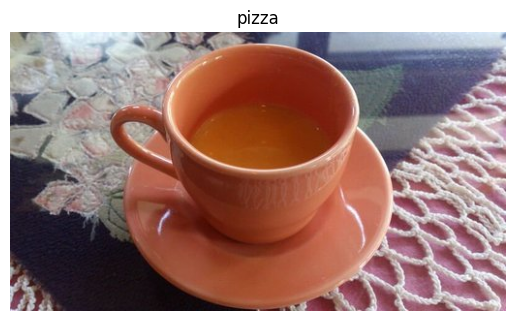

In [47]:
# View a random image of the training dataset
img = view_random_image(target_dir= 'pizza_steak/train/', # we need that slash /
                        target_class= 'pizza')

In [48]:
img.shape # returns height, width and colour channels

(288, 512, 3)

## An end to end example

Let's build a convolutional nn to find patterns in our images:
1. Load our images
2. Preprocess the images
3. Bild a CNN to find patterns
4. Compile the CNN
5. Fit the cnn on our training data

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess the data - scale it to have all the values between 0 and 1
train_datagen  =  ImageDataGenerator(rescale = 1./255.)
valid_datagen = ImageDataGenerator(rescale = 1./255.)

# setup paths to our directories
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# Import data from directories and tuurn it into !batches!
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224, 224), # common shape, keeps a lot of information
                                               class_mode = 'binary',
                                               seed = 42)
valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = 'binary',
                                               seed = 42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [50]:
# Build a CNN model (tiny VGG model !CNN explainer website!)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           activation = 'relu',
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = 'valid'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(2), # is pool size
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the CNN
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = 'accuracy')

# Fit the model
#history_1 = model_1.fit(train_data, # we have the labels thanks to the method flow_from_directory
#                        epochs = 5,
#                        steps_per_epoch = len(train_data),
#                        validation_data = valid_data,
#                        validation_steps = len(valid_data))

**What is a tiny VGG?**
**CNN explainer website** - visit

In [51]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_11 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_13 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

## Using the same model

In [52]:
# set the seed
tf.random.set_seed(42)

# Create
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the CNN
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = 'accuracy')

# Fit the model
#history_2 = model_2.fit(train_data,
#                        epochs = 5,
#                        steps_per_epoch = len(train_data),
#                        validation_data = valid_data,
#                        validation_steps = len(valid_data))

In [53]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 150528)            0         
                                                                 
 dense_11 (Dense)            (None, 4)                 602116    
                                                                 
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
# Improving the dense model
#set seed
tf.random.set_seed(42)

# Create
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
    tf.keras.layers.Dense(100, activation = 'relu'), # increase no of hidden units
    tf.keras.layers.Dense(100, activation = 'relu'), # and no of layers
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the CNN
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = 'accuracy')

# Fit the model
#history_3 = model_3.fit(train_data,
#                        epochs = 5,
#                        steps_per_epoch = len(train_data),
#                        validation_data = valid_data,
#                        validation_steps = len(valid_data))

## Breaking down the CNN creation

Into steps
1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data
3. Create a model
4. Fit the model
5. Evaluate the model
6. Adjust parameters and improve the model
7. Repeat 4., 5., 6. until satisfied

### 1. Become one with the data

['2489716.jpg']
Image shape: (512, 512, 3)
['3595758.jpg']
Image shape: (512, 512, 3)


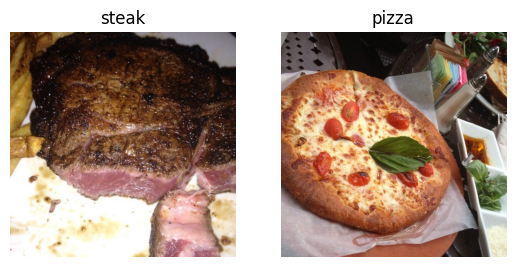

In [55]:
# visualize the data (random samples based on our custom function)
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image('pizza_steak/train/','steak')
plt.subplot(1,2,2)
steak_img = view_random_image('pizza_steak/train/','pizza')

### 2. Preprocess the data (prepare it for the model)

In [56]:
# Define directory dataset paths
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

Turning our data into **batches**

A batch is a small subset of data. Instead of looking at all images at a time it can look only at e.g. 32 of them

In [57]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [58]:
# Create train and test data generators and rescale data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.) # when loading images, divide all pixel values by 255.
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [59]:
# Load the image data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size = (224,224), # the size we want to pass into our nn (height,width)
                                               class_mode = 'binary',
                                               batch_size = 32) #arrange the data into batches of size 32 when loading
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               target_size = (224,224),
                                               class_mode = 'binary',
                                               batch_size = 32) # default is 32 so not needed. However explicit > implicit

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [60]:
# Get a sample of training data batch
images, labels = train_data.next() # get the next batch of images, labels
len(images), len(labels)

(32, 32)

In [61]:
# How many batches are there?
len(train_data)

47

In [62]:
1500/32 # 1500 images groupped into 32-image batches

46.875

In [63]:
# Get the first two images of the first batch
images[0], images[0].shape

(array([[[0.21568629, 0.1254902 , 0.10196079],
         [0.20784315, 0.11764707, 0.09411766],
         [0.20784315, 0.11764707, 0.09411766],
         ...,
         [0.2509804 , 0.227451  , 0.16470589],
         [0.25490198, 0.23137257, 0.16862746],
         [0.24705884, 0.22352943, 0.16078432]],
 
        [[0.21568629, 0.1254902 , 0.10196079],
         [0.20784315, 0.11764707, 0.09411766],
         [0.20784315, 0.11764707, 0.09411766],
         ...,
         [0.24705884, 0.22352943, 0.1764706 ],
         [0.2392157 , 0.21568629, 0.16862746],
         [0.24705884, 0.22352943, 0.1764706 ]],
 
        [[0.21568629, 0.1254902 , 0.10196079],
         [0.20784315, 0.11764707, 0.09411766],
         [0.20784315, 0.11764707, 0.09411766],
         ...,
         [0.25490198, 0.227451  , 0.20392159],
         [0.2392157 , 0.21176472, 0.18823531],
         [0.25882354, 0.23137257, 0.20784315]],
 
        ...,
 
        [[0.0627451 , 0.03137255, 0.01960784],
         [0.05882353, 0.02745098, 0.01568

In [64]:
# View the firts batch of labels
labels

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

### 3. Create a model

Start with a baseline - a fairly simple model or an existing one. When you construct a model you intend to beat the baseline

paperswithcode.com

In [65]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [66]:
# Create a baseline - three layer convolutional net
model_4 = Sequential([
    Conv2D(filters = 10, # the first argument - basically neurons
           kernel_size = 3, # how many pixels to filter at once. If integer n then equivalent to tuple (n, n)
           strides = 1, # how many pixels to pass while changing the filtered kernel. Default: 1
           padding = 'valid', # to expand the image by a frame in order to have the same shape after filtering or not default: 'valid'
           activation = 'relu',
           input_shape = (224, 224, 3)), # input layer needs to have the input shape specified
    Conv2D(10, 3, activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    Flatten(), # so that the output layer has onedimensional inputs
    Dense(1, activation = 'sigmoid')
])

In [67]:
# Compile the model
model_4.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = 'accuracy')

In [68]:
# Get a summary of our model how the input shape changes throughout
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_15 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_16 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_8 (Flatten)         (None, 475240)            0         
                                                                 
 dense_18 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4. Fit the model

In [69]:
# check the lengths of training and test data
len(train_data), len(test_data)

(47, 16)

In [70]:
# Fit the model
#history_4 = model_4.fit(train_data, # has the labels already in
#                        epochs = 5,
#                        steps_per_epoch = len(train_data), # these three are important when you have the datat in batches
#                        validation_data = test_data,
#                        validation_steps = len(test_data))

### 5. Evaluating the net

* check out the training curves
* use accuracy, recall, precision
* confusion matrix

<Axes: >

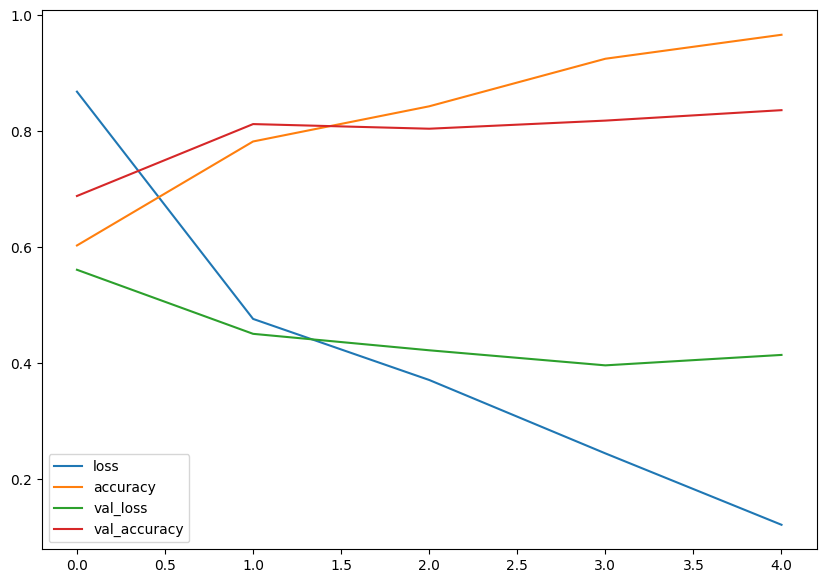

In [71]:
# plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize = (10,7))

In [72]:
# PLot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate training loss curves for training and validation sets
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot loss
  plt.figure()
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()



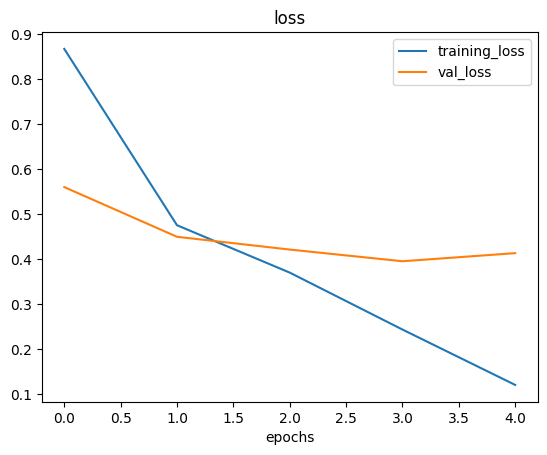

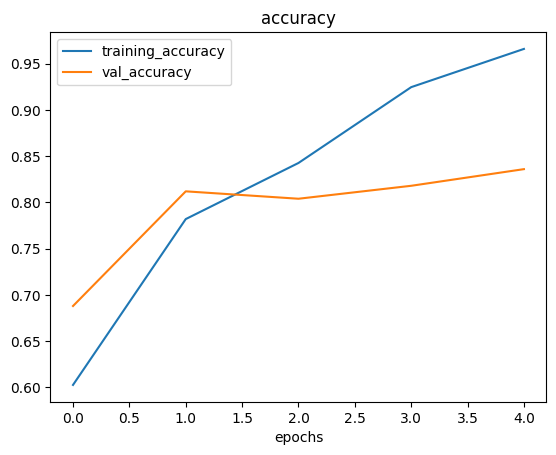

In [73]:
# check out the loss and accuracy of model
plot_loss_curves(history_4)

Validation loss isn't decreasing - the model is overfitting

### 6. Adjust the parameters and combat overfitting

Fitting a ml model comes in 3 steps
0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:
* increase No of conv layers
* increase No of conv filtes
* add another dense layer to the output of the flattened layer

Ways to reduce overfitting:
* add data augmentation
* add regularization layers (e.g. MaxPool2D)
* add more data

Reducing overfitting is also called 'regularization'

In [74]:
# Build a model with MaxPool2D layers
model_5 = Sequential([
    Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
    MaxPool2D(pool_size = 2), # choose the max pixel out of a (2, 2) kernel
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(2), # the first argument is the pool_size. The default is 2 so it is optional
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid') # binary classification
])

In [75]:
# compile the model
model_5.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = 'accuracy')

In [76]:
# fit the model
#history_5 = model_5.fit(train_data,
#                        epochs = 5,
#                        validation_data = test_data,
#                        steps_per_epoch = len(train_data),
#                        validation_steps = len(test_data))

In [77]:
# Get a summary of the model
model_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 26, 26, 10)       

Despite having ca 50 times less parameters than model_4, the performance is better

In [78]:
# Plot loss curves using our fancy function
plot_loss_curves(history_5)

NameError: ignored

### Reduce overfitting by adding data augmentation



In [79]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale = 1./255.,
                                             rotation_range = 1,
                                             shear_range = 0.2,
                                             zoom_range = 0.2,
                                             width_shift_range = 0.1,
                                             height_shift_range = 0.1,
                                             horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)




What is data augmentation?

The process of altering the training data to have more diversity and allow the model to learn more generalizable patterns

In [80]:
# Import data and augment it from training directory
print('Augmented training data')
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size = (224, 224),
                                                                   class_mode = 'binary',
                                                                   shuffle = False) # for demonstration only

print('Non-augmented training data')
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size = (224,224),
                                               class_mode = 'binary',
                                               shuffle = False)
print('Non-augmented test data')
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               target_size = (224,224),
                                               class_mode = 'binary')


Augmented training data
Found 1500 images belonging to 2 classes.
Non-augmented training data
Found 1500 images belonging to 2 classes.
Non-augmented test data
Found 500 images belonging to 2 classes.


Data augmentation usually only happens on the training data.

Using ImageDataGenerator the images inthe directory are left as they are but modified as they enter the model



In [81]:
# get sample augmented data batches
images, labels = train_data.next()
images_augmented, labels_augmented = train_data_augmented.next()

Showing image number:25


(-0.5, 223.5, 223.5, -0.5)

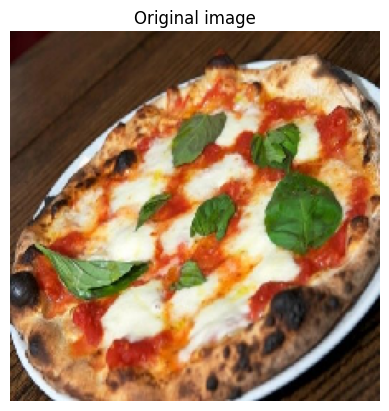

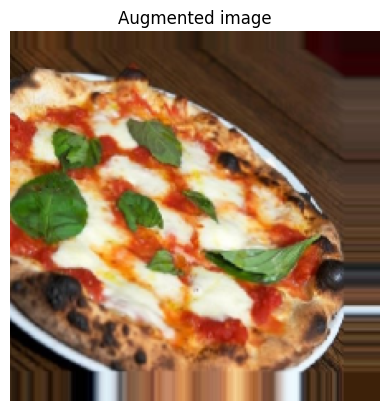

In [82]:
# Show the original image and the augmented one
import random
random_number = random.randint(0,32)
print(f'Showing image number:{random_number}')
plt.imshow(images[random_number])
plt.title('Original image')
plt.axis(False)
plt.figure()
plt.imshow(images_augmented[random_number])
plt.title('Augmented image')
plt.axis(False)

In [83]:
# Build the same model as model_5 but train it on new data
model_6 = Sequential([
    Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
    MaxPool2D(pool_size = 2), # choose the max pixel out of a (2, 2) kernel
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(2), # the first argument is the pool_size. The default is 2 so it is optional
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid') # binary classification
])

In [84]:
# Compile the model
model_6.compile(Adam(), 'binary_crossentropy', 'accuracy')

In [86]:
# Fit the model
history_6 = model_6.fit(train_data_augmented,
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 66s 1s/step - loss: 0.7514 - accuracy: 0.4420 - val_loss: 0.6924 - val_accuracy: 0.5040
Epoch 2/5
47/47 [==============================] - 71s 2s/step - loss: 0.6922 - accuracy: 0.4973 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 64s 1s/step - loss: 0.6902 - accuracy: 0.5013 - val_loss: 0.6820 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 68s 1s/step - loss: 0.6841 - accuracy: 0.5000 - val_loss: 0.6629 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 65s 1s/step - loss: 0.6824 - accuracy: 0.5040 - val_loss: 0.6674 - val_accuracy: 0.5340


In [1]:
# Plot our models training curves
plot_loss_curves(history_6)

NameError: ignored